In [2]:
import os
import pandas as pd
import xarray as xr
from sqlalchemy import create_engine
from dotenv import load_dotenv
import earthaccess

# Step 1: Login and Download Data
auth = earthaccess.login()

# Define DOI, date range, and other search parameters
doi_code = "10.5067/QJ7C8LRUZR8C"
start_date = "2020-01-01"
end_date = "2020-12-31"

# Search and retrieve data
results = earthaccess.search_data(
    doi=doi_code,
    temporal=(start_date, end_date),
    bounding_box=(-180, -90, 180, 90),
    short_name='GLDAS_NOAH10_M'
)

fs = earthaccess.open(results)  # Get file URLs

# Load the dataset
ds = xr.open_mfdataset(fs, chunks=None)  # Adjust chunks if large dataset causes memory issues

# Step 2: Initialize an empty master DataFrame to store all combined data
master_df = pd.DataFrame()

# Step 3: Loop Over Variables and Merge with Master DataFrame
for var_name, variable_data in ds.data_vars.items():
    print(f"Processing variable: {var_name}")
    
    # Check if 'lon' and 'lat' are in the dimensions
    if 'lon' not in variable_data.dims or 'lat' not in variable_data.dims:
        print(f"Skipping {var_name} as it lacks 'lon' and 'lat' dimensions.")
        continue  # Skip this variable if it lacks spatial dimensions
    
    # Initialize an empty list to store monthly data
    monthly_data = []

    # Get the number of time steps (months)
    num_time_steps = len(variable_data['time'])

    # Loop through each time step and process data for each month
    for time_index in range(num_time_steps):
        # Extract data for the current month
        monthly_data_at_time = variable_data.isel(time=time_index).to_dataframe().reset_index()

        # Check and drop NaN values for the specific variable
        if not monthly_data_at_time[var_name].isna().all():
            monthly_data_at_time = monthly_data_at_time.dropna(subset=[var_name])
            monthly_data.append(monthly_data_at_time)

    # Concatenate monthly data into a single DataFrame for the variable
    if monthly_data:
        final_df = pd.concat(monthly_data, ignore_index=True)
        
        # Perform aggregation
        aggregated_df = final_df.groupby(['lon', 'lat']).agg(
            min_value=(var_name, 'min'),
            max_value=(var_name, 'max'),
            avg_value=(var_name, 'mean')
        ).reset_index()
        
        # Rename columns to include the variable name
        aggregated_df.rename(columns={
            'min_value': f'{var_name}_min',
            'max_value': f'{var_name}_max',
            'avg_value': f'{var_name}_avg'
        }, inplace=True)
        
        # Merge with the master DataFrame using an outer join on 'lon' and 'lat'
        if master_df.empty:
            master_df = aggregated_df  # If master_df is empty, initialize it with the first variable's data
        else:
            master_df = pd.merge(master_df, aggregated_df, on=['lon', 'lat'], how='outer')

    else:
        print(f"No valid data available for {var_name} during the selected time period.")

# Step 4: Save the Combined DataFrame to CSV
csv_filename = "combined_satellite_data_2020.csv"
master_df.to_csv(csv_filename, index=False)
print(f"Combined data saved to {csv_filename}")

# Step 5: Upload Combined Data to PostgreSQL Database
# Load environment variables
load_dotenv()
POSTGRES_USER = os.getenv('POSTGRES_USER')
POSTGRES_PASS = os.getenv('POSTGRES_PASS')
POSTGRES_HOST = os.getenv('POSTGRES_HOST')
POSTGRES_PORT = os.getenv('POSTGRES_PORT', '5432')
POSTGRES_DB = os.getenv('POSTGRES_DB')

# Create a database connection string and engine
connection_string = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASS}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
engine = create_engine(connection_string)

# Define table name for the combined data
table_name = "ecosystem_classifier.combined_satellite_data_2020"

# Upload the DataFrame to the SQL table
master_df.to_sql(table_name, engine, if_exists='replace', index=False)
print(f"Combined data uploaded to {table_name} successfully.")

QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

Processing variable: time_bnds
Skipping time_bnds as it lacks 'lon' and 'lat' dimensions.
Processing variable: Swnet_tavg
Processing variable: Lwnet_tavg
Processing variable: Qle_tavg
Processing variable: Qh_tavg
Processing variable: Qg_tavg
Processing variable: Snowf_tavg
Processing variable: Rainf_tavg
Processing variable: Evap_tavg
Processing variable: Qs_acc
Processing variable: Qsb_acc
Processing variable: Qsm_acc
Processing variable: AvgSurfT_inst
Processing variable: Albedo_inst
Processing variable: SWE_inst
Processing variable: SnowDepth_inst
Processing variable: SoilMoi0_10cm_inst
Processing variable: SoilMoi10_40cm_inst
Processing variable: SoilMoi40_100cm_inst
Processing variable: SoilMoi100_200cm_inst
Processing variable: SoilTMP0_10cm_inst
Processing variable: SoilTMP10_40cm_inst
Processing variable: SoilTMP40_100cm_inst
Processing variable: SoilTMP100_200cm_inst
Processing variable: PotEvap_tavg
Processing variable: ECanop_tavg
Processing variable: Tveg_tavg
Processing va

ProgrammingError: (psycopg2.errors.InsufficientPrivilege) permission denied for schema public
LINE 2: CREATE TABLE "ecosystem_classifier.combined_satellite_data_2...
                     ^

[SQL: 
CREATE TABLE "ecosystem_classifier.combined_satellite_data_2020" (
	lon FLOAT(23), 
	lat FLOAT(23), 
	"Swnet_tavg_min" FLOAT(23), 
	"Swnet_tavg_max" FLOAT(23), 
	"Swnet_tavg_avg" FLOAT(23), 
	"Lwnet_tavg_min" FLOAT(23), 
	"Lwnet_tavg_max" FLOAT(23), 
	"Lwnet_tavg_avg" FLOAT(23), 
	"Qle_tavg_min" FLOAT(23), 
	"Qle_tavg_max" FLOAT(23), 
	"Qle_tavg_avg" FLOAT(23), 
	"Qh_tavg_min" FLOAT(23), 
	"Qh_tavg_max" FLOAT(23), 
	"Qh_tavg_avg" FLOAT(23), 
	"Qg_tavg_min" FLOAT(23), 
	"Qg_tavg_max" FLOAT(23), 
	"Qg_tavg_avg" FLOAT(23), 
	"Snowf_tavg_min" FLOAT(23), 
	"Snowf_tavg_max" FLOAT(23), 
	"Snowf_tavg_avg" FLOAT(23), 
	"Rainf_tavg_min" FLOAT(23), 
	"Rainf_tavg_max" FLOAT(23), 
	"Rainf_tavg_avg" FLOAT(23), 
	"Evap_tavg_min" FLOAT(23), 
	"Evap_tavg_max" FLOAT(23), 
	"Evap_tavg_avg" FLOAT(23), 
	"Qs_acc_min" FLOAT(23), 
	"Qs_acc_max" FLOAT(23), 
	"Qs_acc_avg" FLOAT(23), 
	"Qsb_acc_min" FLOAT(23), 
	"Qsb_acc_max" FLOAT(23), 
	"Qsb_acc_avg" FLOAT(23), 
	"Qsm_acc_min" FLOAT(23), 
	"Qsm_acc_max" FLOAT(23), 
	"Qsm_acc_avg" FLOAT(23), 
	"AvgSurfT_inst_min" FLOAT(23), 
	"AvgSurfT_inst_max" FLOAT(23), 
	"AvgSurfT_inst_avg" FLOAT(23), 
	"Albedo_inst_min" FLOAT(23), 
	"Albedo_inst_max" FLOAT(23), 
	"Albedo_inst_avg" FLOAT(23), 
	"SWE_inst_min" FLOAT(23), 
	"SWE_inst_max" FLOAT(23), 
	"SWE_inst_avg" FLOAT(23), 
	"SnowDepth_inst_min" FLOAT(23), 
	"SnowDepth_inst_max" FLOAT(23), 
	"SnowDepth_inst_avg" FLOAT(23), 
	"SoilMoi0_10cm_inst_min" FLOAT(23), 
	"SoilMoi0_10cm_inst_max" FLOAT(23), 
	"SoilMoi0_10cm_inst_avg" FLOAT(23), 
	"SoilMoi10_40cm_inst_min" FLOAT(23), 
	"SoilMoi10_40cm_inst_max" FLOAT(23), 
	"SoilMoi10_40cm_inst_avg" FLOAT(23), 
	"SoilMoi40_100cm_inst_min" FLOAT(23), 
	"SoilMoi40_100cm_inst_max" FLOAT(23), 
	"SoilMoi40_100cm_inst_avg" FLOAT(23), 
	"SoilMoi100_200cm_inst_min" FLOAT(23), 
	"SoilMoi100_200cm_inst_max" FLOAT(23), 
	"SoilMoi100_200cm_inst_avg" FLOAT(23), 
	"SoilTMP0_10cm_inst_min" FLOAT(23), 
	"SoilTMP0_10cm_inst_max" FLOAT(23), 
	"SoilTMP0_10cm_inst_avg" FLOAT(23), 
	"SoilTMP10_40cm_inst_min" FLOAT(23), 
	"SoilTMP10_40cm_inst_max" FLOAT(23), 
	"SoilTMP10_40cm_inst_avg" FLOAT(23), 
	"SoilTMP40_100cm_inst_min" FLOAT(23), 
	"SoilTMP40_100cm_inst_max" FLOAT(23), 
	"SoilTMP40_100cm_inst_avg" FLOAT(23), 
	"SoilTMP100_200cm_inst_min" FLOAT(23), 
	"SoilTMP100_200cm_inst_max" FLOAT(23), 
	"SoilTMP100_200cm_inst_avg" FLOAT(23), 
	"PotEvap_tavg_min" FLOAT(23), 
	"PotEvap_tavg_max" FLOAT(23), 
	"PotEvap_tavg_avg" FLOAT(23), 
	"ECanop_tavg_min" FLOAT(23), 
	"ECanop_tavg_max" FLOAT(23), 
	"ECanop_tavg_avg" FLOAT(23), 
	"Tveg_tavg_min" FLOAT(23), 
	"Tveg_tavg_max" FLOAT(23), 
	"Tveg_tavg_avg" FLOAT(23), 
	"ESoil_tavg_min" FLOAT(23), 
	"ESoil_tavg_max" FLOAT(23), 
	"ESoil_tavg_avg" FLOAT(23), 
	"RootMoist_inst_min" FLOAT(23), 
	"RootMoist_inst_max" FLOAT(23), 
	"RootMoist_inst_avg" FLOAT(23), 
	"CanopInt_inst_min" FLOAT(23), 
	"CanopInt_inst_max" FLOAT(23), 
	"CanopInt_inst_avg" FLOAT(23), 
	"Wind_f_inst_min" FLOAT(23), 
	"Wind_f_inst_max" FLOAT(23), 
	"Wind_f_inst_avg" FLOAT(23), 
	"Rainf_f_tavg_min" FLOAT(23), 
	"Rainf_f_tavg_max" FLOAT(23), 
	"Rainf_f_tavg_avg" FLOAT(23), 
	"Tair_f_inst_min" FLOAT(23), 
	"Tair_f_inst_max" FLOAT(23), 
	"Tair_f_inst_avg" FLOAT(23), 
	"Qair_f_inst_min" FLOAT(23), 
	"Qair_f_inst_max" FLOAT(23), 
	"Qair_f_inst_avg" FLOAT(23), 
	"Psurf_f_inst_min" FLOAT(23), 
	"Psurf_f_inst_max" FLOAT(23), 
	"Psurf_f_inst_avg" FLOAT(23), 
	"SWdown_f_tavg_min" FLOAT(23), 
	"SWdown_f_tavg_max" FLOAT(23), 
	"SWdown_f_tavg_avg" FLOAT(23), 
	"LWdown_f_tavg_min" FLOAT(23), 
	"LWdown_f_tavg_max" FLOAT(23), 
	"LWdown_f_tavg_avg" FLOAT(23)
)

]
(Background on this error at: https://sqlalche.me/e/20/f405)

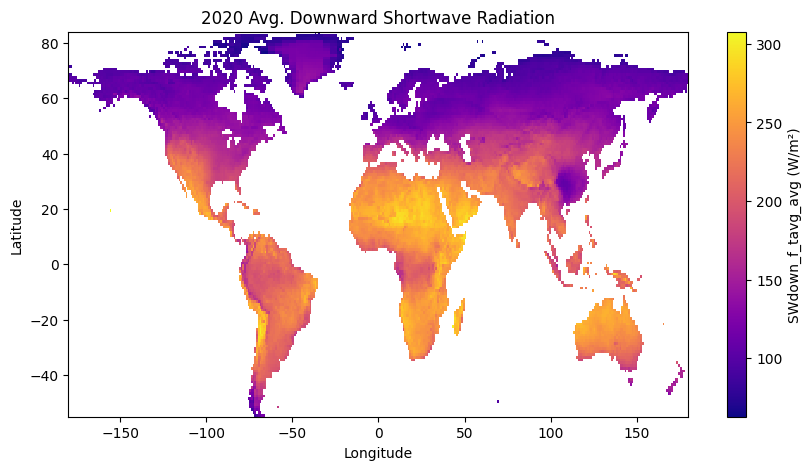

In [3]:
import matplotlib.pyplot as plt

# Aggregate by averaging SWdown_f_tavg_avg for each (lat, lon) combination (if not already aggregated)
aggregated_df = master_df.groupby(['lat', 'lon'], as_index=False)['SWdown_f_tavg_avg'].mean()

# Pivot to create a 2D grid with latitude as rows and longitude as columns
pivot_df = aggregated_df.pivot(index='lat', columns='lon', values='SWdown_f_tavg_avg')

# Plot using pcolormesh
plt.figure(figsize=(10, 5))
plt.pcolormesh(pivot_df.columns, pivot_df.index, pivot_df.values, cmap='plasma', shading='nearest')
plt.colorbar(label='SWdown_f_tavg_avg (W/m²)')
plt.title("2020 Avg. Downward Shortwave Radiation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [30]:
master_df['delta_albedo']=master_df['Albedo_inst_max']-master_df['Albedo_inst_min']
master_df.head()

,lon,lat,Swnet_tavg_min,Swnet_tavg_max,Swnet_tavg_avg,Lwnet_tavg_min,Lwnet_tavg_max,Lwnet_tavg_avg,Qle_tavg_min,Qle_tavg_max,...,Psurf_f_inst_max,Psurf_f_inst_avg,SWdown_f_tavg_min,SWdown_f_tavg_max,SWdown_f_tavg_avg,LWdown_f_tavg_min,LWdown_f_tavg_max,LWdown_f_tavg_avg,delta_albebo,delta_albedo
0,-179.5,66.5,0.027379,171.202698,56.415329,-50.027756,-23.959593,-37.748684,0.001239,32.995209,...,100353.304688,99864.218750,0.087137,254.396210,102.719322,152.496094,330.060333,242.624191,67.341705,67.341705
1,-179.5,67.5,0.000000,179.749115,55.889511,-55.681705,-19.460226,-34.698853,-0.392431,38.654583,...,96306.015625,95717.906250,0.000000,249.185959,101.117043,145.439545,319.185608,231.317871,64.576355,64.576355
2,-179.5,68.5,0.000000,170.543381,50.445389,-51.279892,-18.687616,-33.223457,-0.406950,28.063959,...,96911.078125,96309.773438,0.000000,234.095367,91.448265,150.033432,315.471497,234.093094,65.905083,65.905083
3,-179.5,71.5,0.000000,200.258087,53.217823,-45.314377,-18.926947,-28.411278,2.463524,34.960304,...,98882.304688,98161.648438,0.000000,248.310410,87.157402,163.617523,309.576782,245.137573,67.548523,67.548523
4,-178.5,66.5,0.032097,173.997498,56.130936,-53.645859,-25.988504,-37.955284,0.012771,37.971958,...,96021.960938,95483.835938,0.092500,256.449341,103.645355,146.282990,313.083160,231.971375,64.154709,64.154709


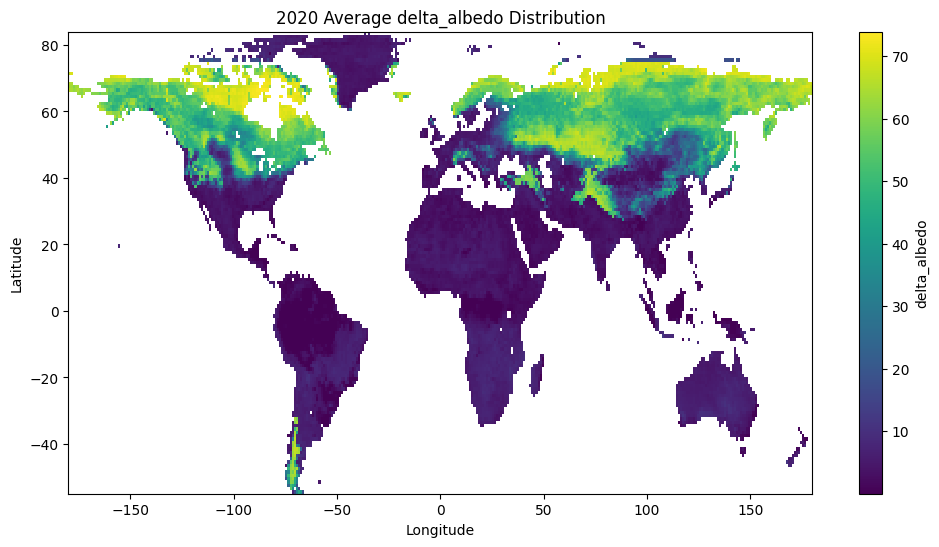

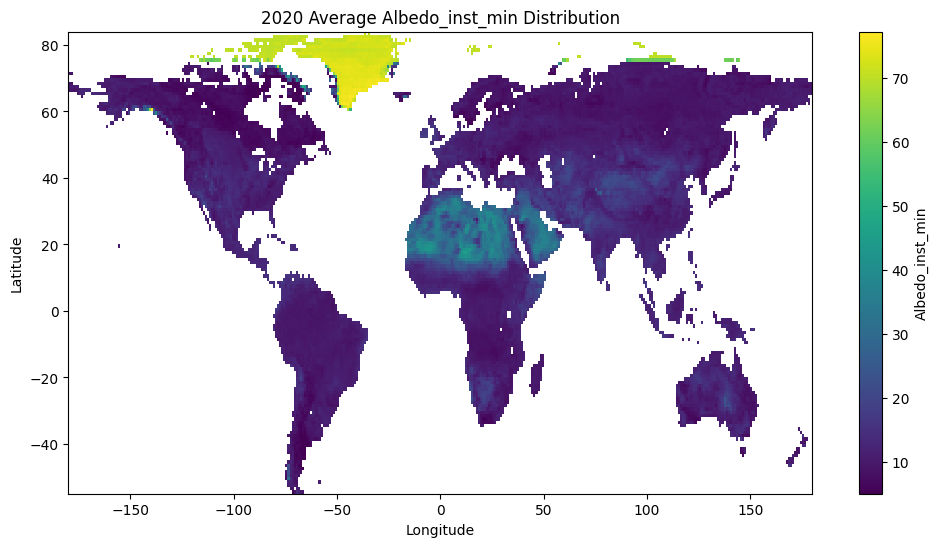

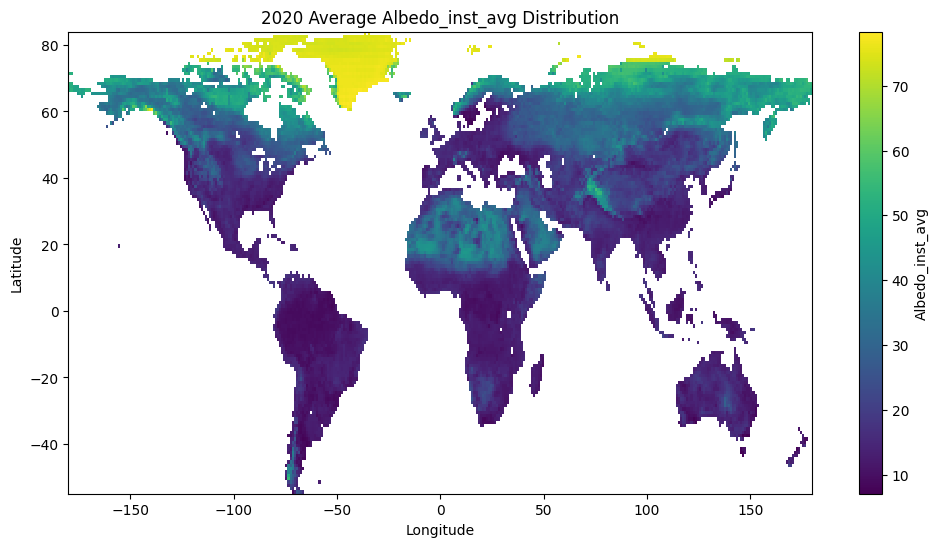

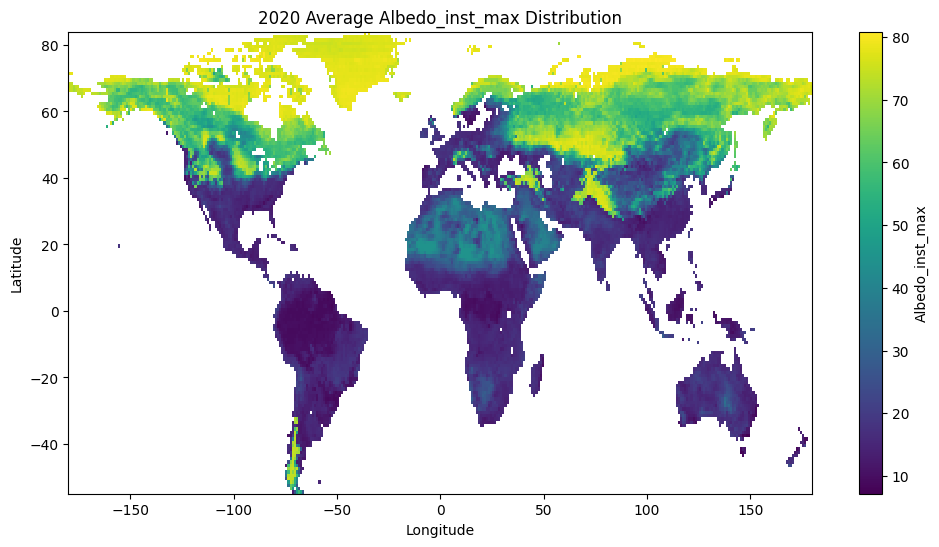

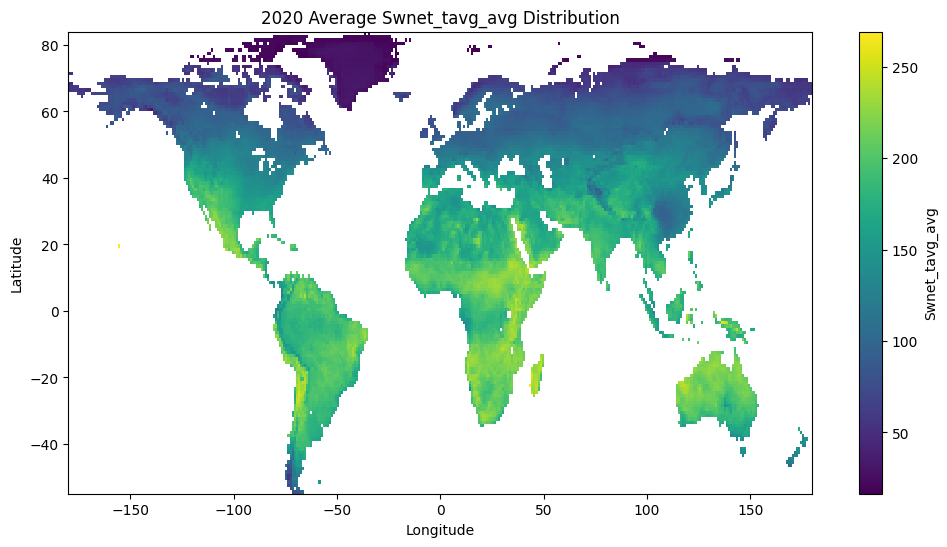

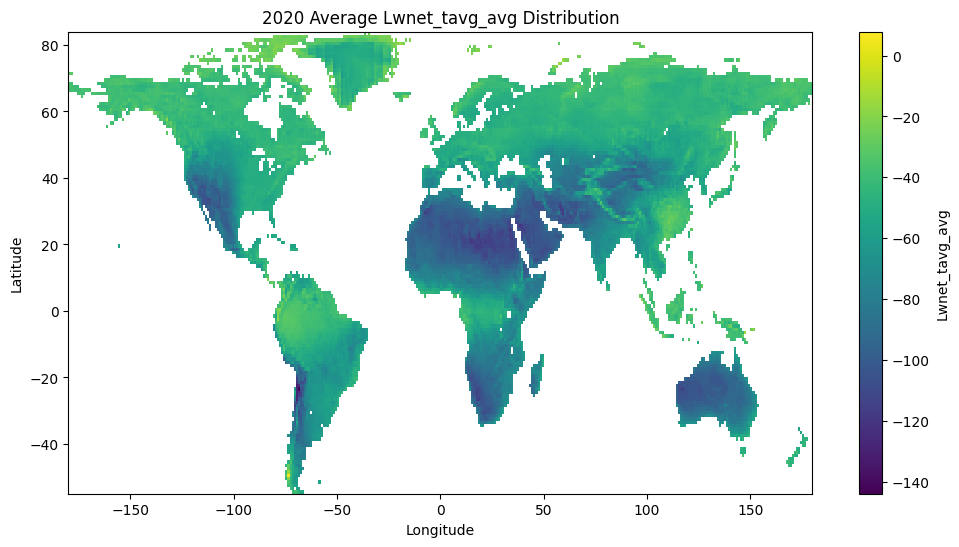

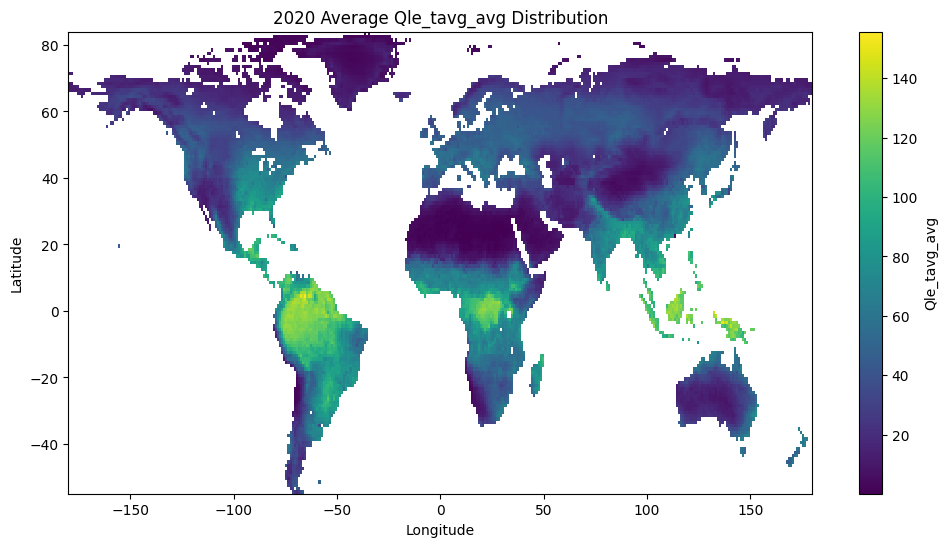

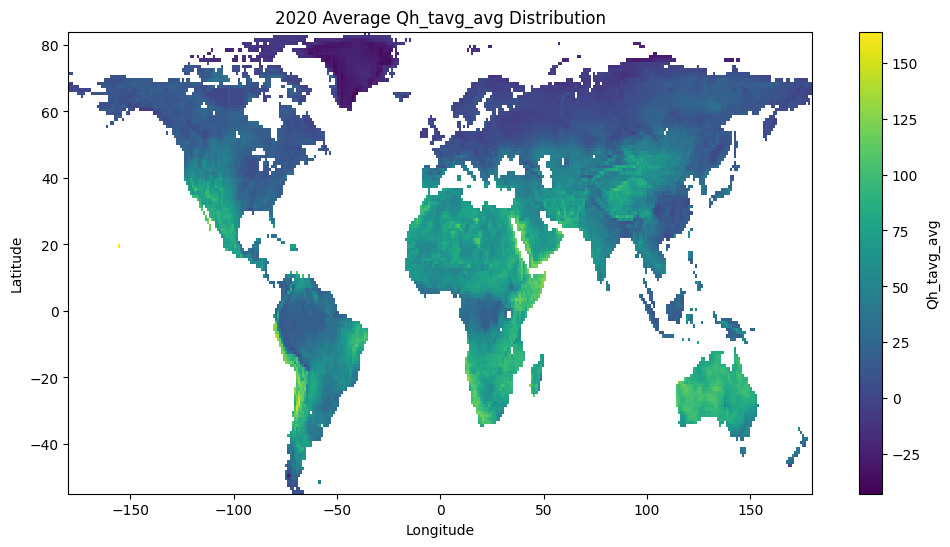

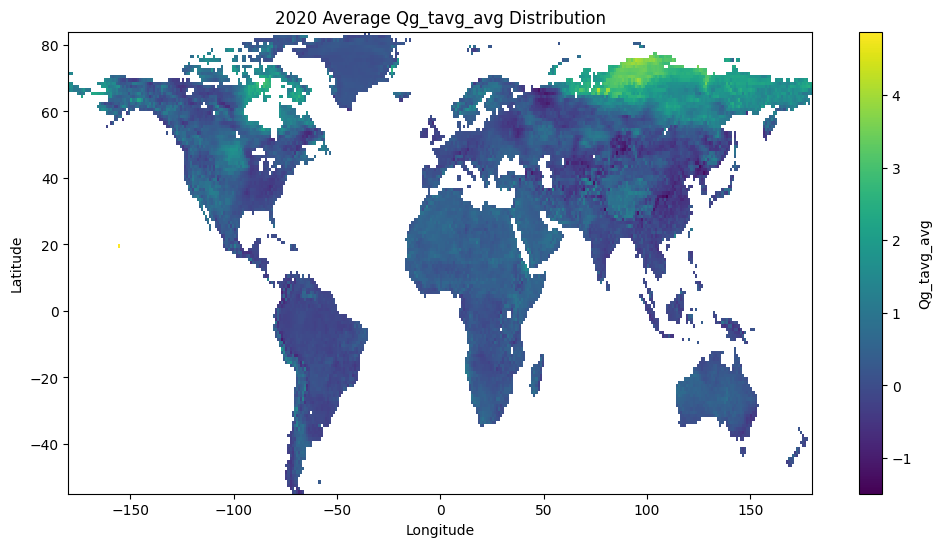

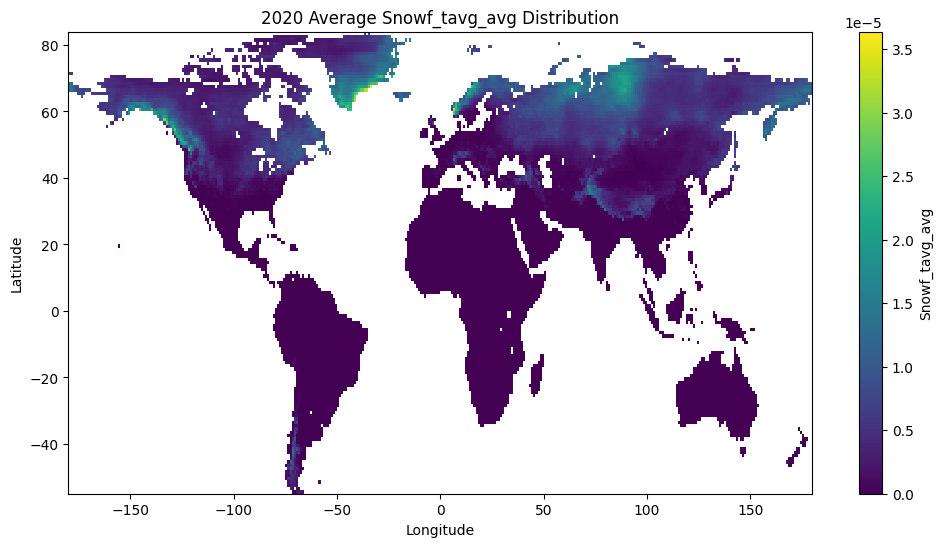

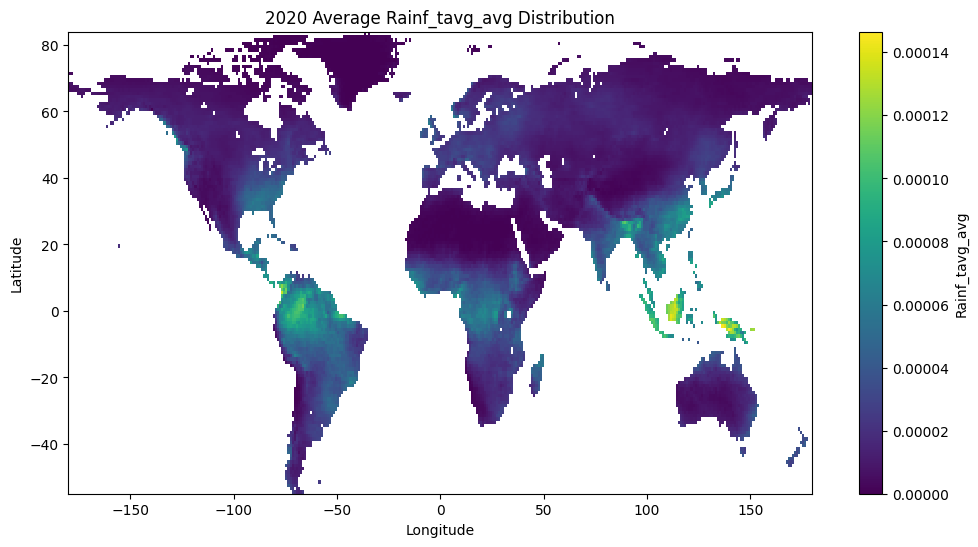

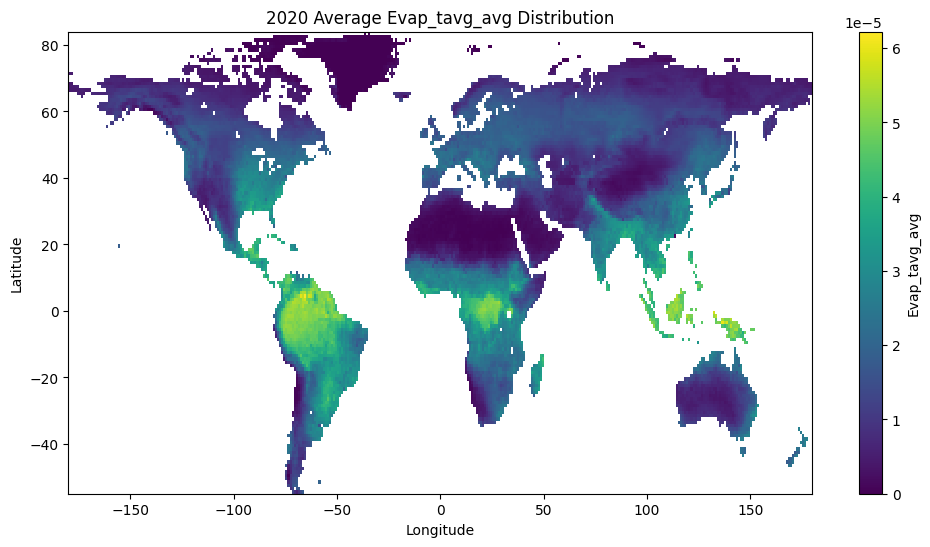

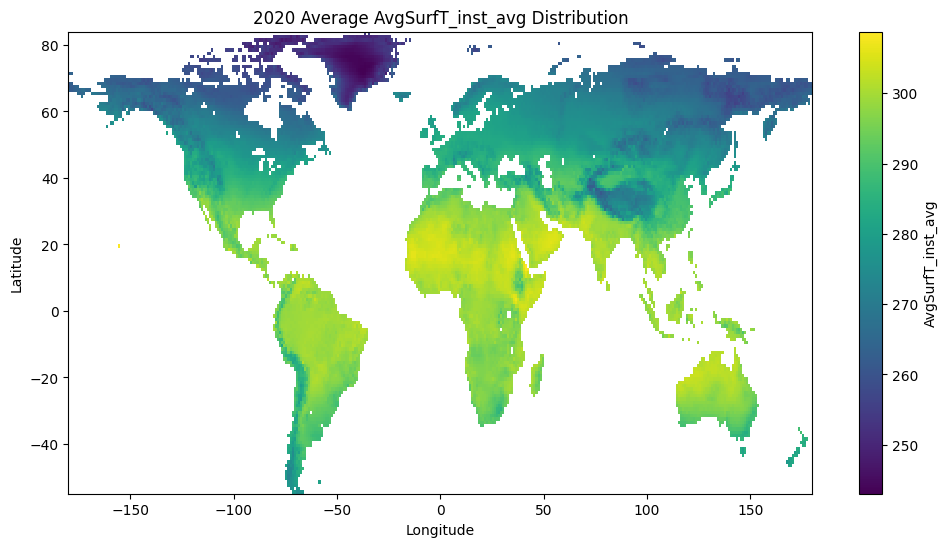

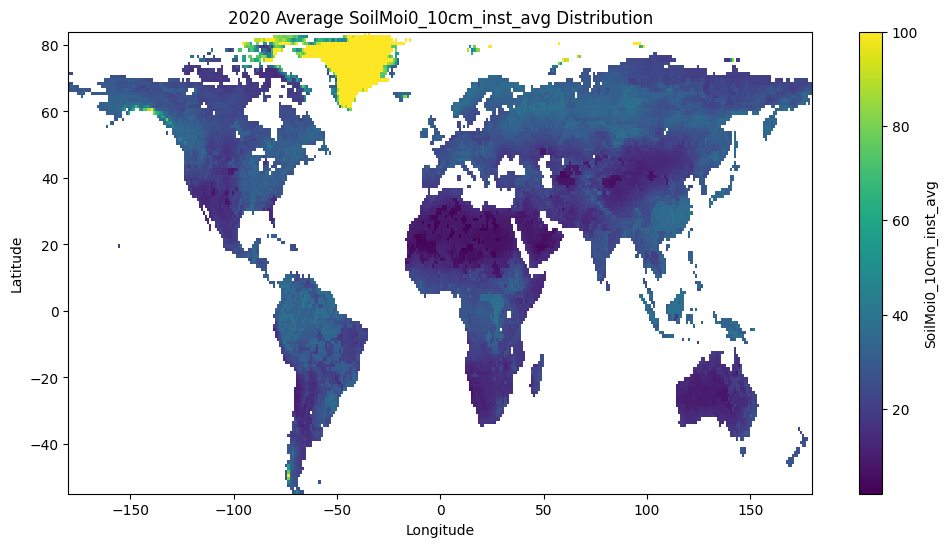

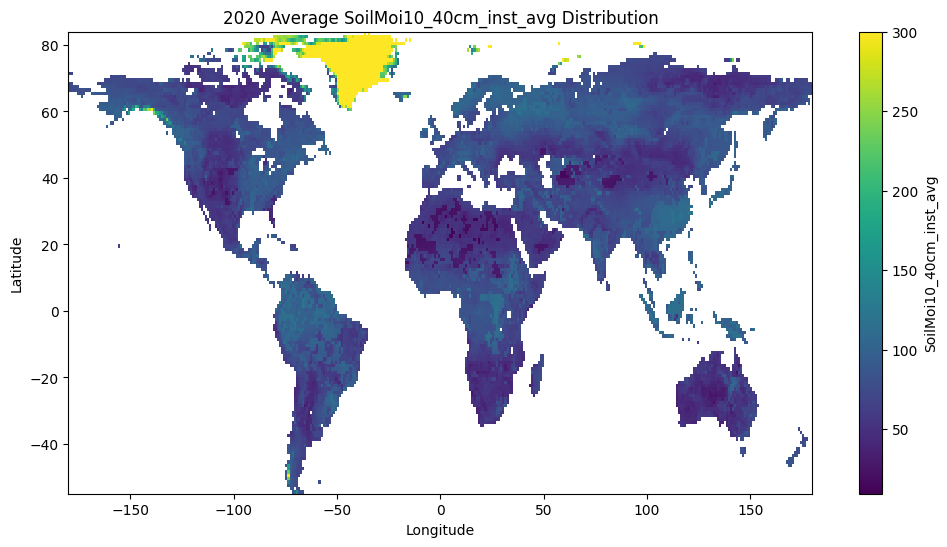

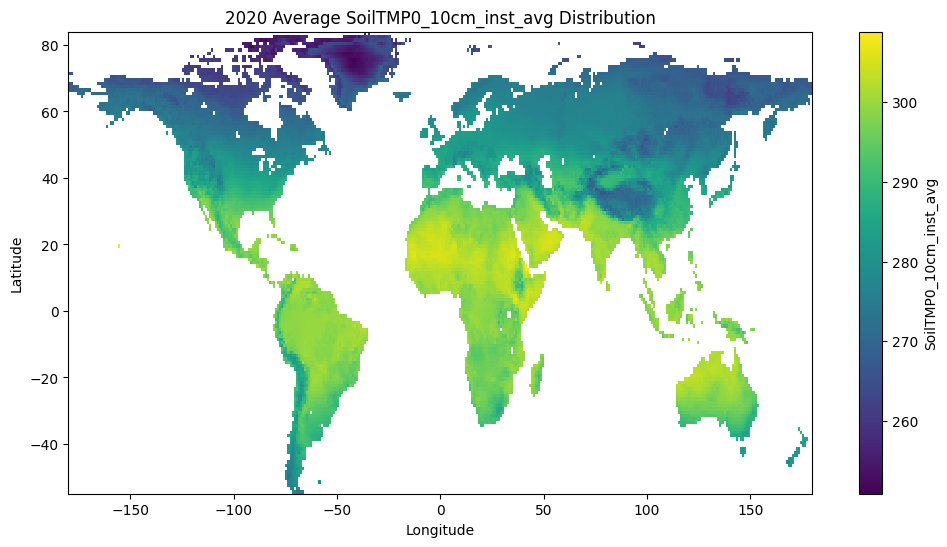

In [ ]:


# List of variables to plot (you can customize this list)
variables_to_plot = [
    'delta_albedo',
    'Albedo_inst_min',
    'Albedo_inst_avg',
    'Albedo_inst_max',
    'Swnet_tavg_avg',
    'Lwnet_tavg_avg',
    'Qle_tavg_avg',
    'Qh_tavg_avg',
    'Qg_tavg_avg',
    'Snowf_tavg_avg',
    'Rainf_tavg_avg',
    'Evap_tavg_avg',
    'AvgSurfT_inst_avg',
    'SoilMoi0_10cm_inst_avg',
    'SoilMoi10_40cm_inst_avg',
    'SoilTMP0_10cm_inst_avg',
    # Add more variables as needed
]

# Loop through the specified variables
for variable_name in variables_to_plot:
    # Check if required columns exist
    if 'lat' in master_df.columns and 'lon' in master_df.columns and variable_name in master_df.columns:
        # Prepare the DataFrame for plotting
        aggregated_df = master_df[['lat', 'lon', variable_name]].copy()
        
        # Pivot the DataFrame to create a 2D grid
        pivot_df = aggregated_df.pivot(index='lat', columns='lon', values=variable_name)
        
        # Create a plot using pcolormesh
        plt.figure(figsize=(12, 6))
        plt.pcolormesh(pivot_df.columns, pivot_df.index, pivot_df.values, cmap='viridis', shading='nearest')
        plt.colorbar(label=variable_name)
        plt.title(f"2020 Average {variable_name} Distribution")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
    else:
        print(f"Required columns are not in the DataFrame for {variable_name}. Please check:", master_df.columns.tolist())

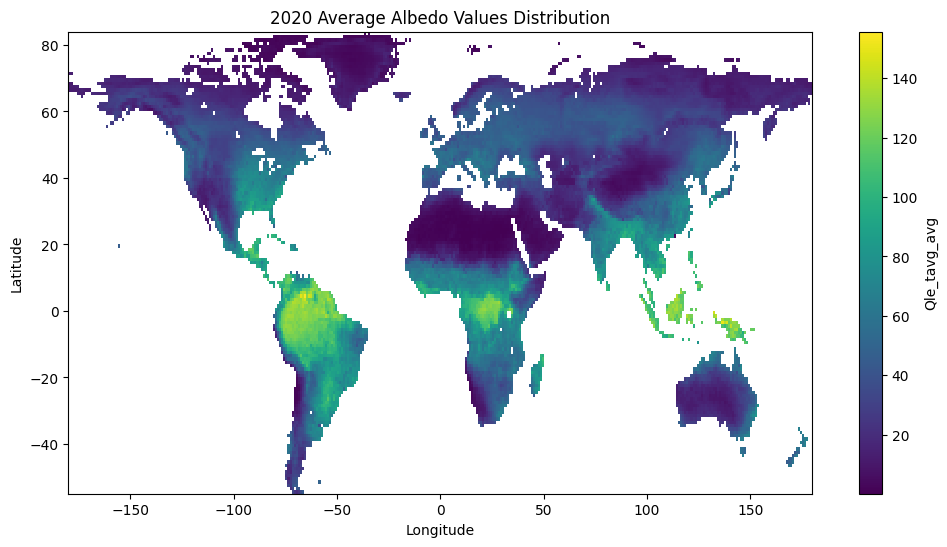

In [ ]:
import matplotlib.pyplot as plt

# Set the variable name for Albedo average
variable_name = 'Albedo_inst_avg'

# Check if required columns exist
if 'lat' in master_df.columns and 'lon' in master_df.columns and variable_name in master_df.columns:
    # Prepare the DataFrame for plotting
    aggregated_df = master_df[['lat', 'lon', variable_name]].copy()
    
    # Pivot the DataFrame to create a 2D grid
    pivot_df = aggregated_df.pivot(index='lat', columns='lon', values=variable_name)
    
    # Create a plot using pcolormesh
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(pivot_df.columns, pivot_df.index, pivot_df.values, cmap='viridis', shading='nearest')
    plt.colorbar(label=variable_name)
    plt.title(f"2020 Average Albedo Values Distribution")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print("Required columns are not in the DataFrame. Please check:", master_df.columns.tolist())

